# Exploring the GDSC dataset

## Dataset notes

- response
  - number of cell lines: 969
  - number of drugs: 295
- gene expression
  - 17737 genes measured
    - 17419 with gene symbol
    - 318 without gene symbol
- drug annotations
  - 608 with identifiable name

## Imports and constants

In [154]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import pandas as pd
import re
import math
import json

In [121]:
datadir = "/Volumes/OXYTOCIN/datasets/gdsc"
response_fname = "GDSC2_fitted_dose_response_24Jul22.xlsx" # drug response data
expr_fname = "Cell_line_RMA_proc_basalExp.txt" # gene expression data
cmpds_fname = "Drug_list Jan 20 2023.csv" # compound metadata
pubchem_fname = "gdsc2_drug_pubchem_info.csv"

## Data exploration

### Drug response data

In [17]:
response = pd.read_excel(f"{datadir}/{response_fname}")

In [73]:
response

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-1.462148,0.930105,0.088999,0.432482
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-4.869447,0.614932,0.111423,-1.420322
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-3.360684,0.790953,0.142754,-0.599894
3,GDSC2,401,18946335,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-5.045014,0.592624,0.135642,-1.515791
4,GDSC2,401,18946617,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-3.741620,0.733992,0.128066,-0.807038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242031,GDSC2,401,19187490,1659928,SNU-175,SIDM00216,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.134495,0.976798,0.074441,0.159946
242032,GDSC2,401,19187943,1660034,SNU-407,SIDM00214,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,8.575555,0.913182,0.057743,-1.626059
242033,GDSC2,401,19188201,1660035,SNU-61,SIDM00194,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.520666,0.974889,0.058094,0.602364
242034,GDSC2,401,19188741,1674021,SNU-C5,SIDM00498,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.701430,0.970009,0.100980,0.809457


In [18]:
# basic info about response dataset
print("num cell lines:", len(response["CELL_LINE_NAME"].unique()))
print("num drugs:", len(response["DRUG_ID"].unique()))

num cell lines: 969
num drugs: 295


### Expression data

In [67]:
df = pd.read_csv(f"{datadir}/{expr_fname}", sep="\t")

In [12]:
len(df.columns)

1020

In [13]:
df.columns

Index(['GENE_SYMBOLS', 'GENE_title', 'DATA.906826', 'DATA.687983',
       'DATA.910927', 'DATA.1240138', 'DATA.1240139', 'DATA.906792',
       'DATA.910688', 'DATA.1240135',
       ...
       'DATA.753584', 'DATA.907044', 'DATA.998184', 'DATA.908145',
       'DATA.1659787', 'DATA.1298157', 'DATA.1480372', 'DATA.1298533',
       'DATA.930299', 'DATA.905954.1'],
      dtype='object', length=1020)

In [34]:
len(df["GENE_SYMBOLS"].dropna()), len(set(df["GENE_SYMBOLS"].dropna())), len(df["GENE_SYMBOLS"])

(17419, 17419, 17737)

### Drug metadata

In [118]:
cmpds = pd.read_csv(f"{datadir}/{cmpds_fname}")

In [119]:
cmpds.columns

Index(['Drug Id', 'Name', 'Synonyms', 'Targets', 'Target pathway', 'PubCHEM',
       'Datasets', 'number of cell lines', 'Screening site'],
      dtype='object')

In [120]:
# keep compounds with pubchem id
cmpds = cmpds[cmpds["Datasets"] == "GDSC2"]
cmpds = cmpds[cmpds["PubCHEM"].notna()]
cmpds = cmpds[cmpds["PubCHEM"] != "None"]
cmpds = cmpds[cmpds["PubCHEM"] != "none"]
cmpds = cmpds[cmpds["PubCHEM"] != "several"]
cmpds["PubCHEM"] = cmpds["PubCHEM"].map(lambda f: f.split(",")[0])
cmpds = cmpds.sort_values(by="PubCHEM")
print(len(cmpds))

186


In [130]:
# read in pubchem additional info
pubchem = pd.read_csv(pubchem_fname, header=None, names=["pubchem_id", "pubchem_json"])
pubchem_dict = {}
for _, row in pubchem.iterrows():
    pubchem_id = row["pubchem_id"]
    pubchem_json = row["pubchem_json"]
    pubchem_dict[pubchem_id] = json.loads(pubchem_json)

In [141]:
# add smiles string
cmpds["SMILES"] = cmpds.apply(lambda r: pubchem_dict[int(r.to_dict()["PubCHEM"])]["canonical_smiles"], axis=1)

In [143]:
cmpds

,Drug Id,Name,Synonyms,Targets,Target pathway,PubCHEM,Datasets,number of cell lines,Screening site,SMILES
131,1037,BX795,BX-795,"TBK1, PDK1 (PDPK1), IKK, AURKB, AURKC","Other, kinases",10077147,GDSC2,225,SANGER,C1CCN(C1)C(=O)NC2=CC=CC(=C2)NC3=NC=C(C(=N3)NCC...
385,1559,Luminespib,"AUY922, VER-52296,NVP-AUY922, AUY",HSP90,Protein stability and degradation,10096043,GDSC2,964,SANGER,CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)O)C(C)C)ON1)C3=...
565,1062,Selumetinib,"AZD6244, AZD-6244, ARRY-886","MEK1, MEK2",ERK MAPK signaling,10127622,GDSC2,949,SANGER,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...
498,1635,Picolinici-acid,Picolinate,Inflammatory related,Other,1018,GDSC2,893,SANGER,C1=CC=NC(=C1)C(=O)O
85,1032,Afatinib,"BIBW2992, Tovok, Gilotrif","EGFR, ERBB2",EGFR signaling,10184653,GDSC2,966,SANGER,CN(C)CC=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(...
...,...,...,...,...,...,...,...,...,...,...
186,1922,Cediranib,"AZD2171, AZD 2171, AZD-2171, Recentin","VEGFR, FLT1, FLT2, FLT3, FLT4, KIT, PDGFRB",RTK signaling,9933475,GDSC2,958,SANGER,CC1=CC2=C(N1)C=CC(=C2F)OC3=NC=NC4=CC(=C(C=C43)...
444,1626,OTX015,"Birabresib, OTX-015, MK-8628","BRD2, BRD3, BRD4",Chromatin other,9936746,GDSC2,893,SANGER,CC1=C(SC2=C1C(=NC(C3=NN=C(N32)C)CC(=O)NC4=CC=C...
221,1069,EHT-1864,EHT 1864,"RAC1, RAC2, RAC3",Cytoskeleton,9938202,GDSC2,943,SANGER,C1COCCN1CC2=CC(=O)C(=CO2)OCCCCCSC3=C4C=CC(=CC4...
295,1023,GW441756,GW 441756,NTRK1,RTK signaling,9943465,GDSC2,953,SANGER,CN1C=C(C2=CC=CC=C21)C=C3C4=C(C=CC=N4)NC3=O


## SMILES to fingerprint

In [148]:
# morgan fingerprint is awful; hash function is likely way too
# difficult for a neural network to learn

bx795_smiles = cmpds["SMILES"].iloc[0]

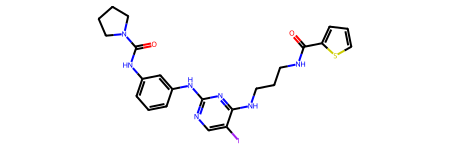

In [150]:
bx795 = Chem.MolFromSmiles(bx795_smiles)
bx795

In [156]:
bi = {}
fcfp = AllChem.GetMorganFingerprint(bx795, 2, useFeatures=True, bitInfo=bi)

In [157]:
fcfp.GetNonzeroElements()

{0: 10,
 1: 2,
 2: 2,
 4: 14,
 6: 3,
 8: 1,
 19: 2,
 109741511: 1,
 128222166: 1,
 193992059: 2,
 239857054: 1,
 317524188: 1,
 594405818: 1,
 613660003: 1,
 614173363: 1,
 614176388: 1,
 666422235: 1,
 728919389: 1,
 728953866: 1,
 728998013: 1,
 729011515: 1,
 729011661: 1,
 756873222: 1,
 761943436: 1,
 1021009427: 1,
 1230563926: 1,
 1230564256: 1,
 1251070542: 1,
 1562420499: 1,
 1690641099: 1,
 1907154955: 1,
 2179844032: 1,
 2716535440: 1,
 2756354407: 1,
 2873949288: 1,
 3205496507: 1,
 3205496824: 2,
 3514530458: 1,
 3532241538: 1,
 3659792644: 1,
 3660059448: 1,
 3662079838: 1,
 3701757961: 1,
 3764335747: 3,
 3764344801: 6,
 3764344823: 2,
 3766528779: 1,
 3766528791: 1,
 3766532888: 5,
 3766532903: 1,
 3766532917: 1,
 3766665719: 1,
 3766674798: 1,
 4182664752: 1,
 4203098518: 1,
 4203103696: 2,
 4203214599: 1}

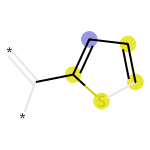

In [159]:
Draw.DrawMorganBit(bx795, 3532241538, bi)

In [160]:
bi

{0: ((0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (22, 0),
  (23, 0),
  (24, 0),
  (26, 0)),
 1: ((7, 0), (25, 0)),
 2: ((6, 0), (27, 0)),
 4: ((8, 0),
  (9, 0),
  (10, 0),
  (11, 0),
  (12, 0),
  (13, 0),
  (15, 0),
  (17, 0),
  (18, 0),
  (19, 0),
  (28, 0),
  (29, 0),
  (30, 0),
  (31, 0)),
 6: ((16, 0), (20, 0), (32, 0)),
 8: ((33, 0),),
 19: ((14, 0), (21, 0)),
 109741511: ((25, 2),),
 128222166: ((15, 2),),
 193992059: ((2, 2), (4, 2)),
 239857054: ((12, 2),),
 317524188: ((18, 2),),
 594405818: ((28, 1),),
 613660003: ((26, 1),),
 614173363: ((5, 1),),
 614176388: ((3, 1),),
 666422235: ((20, 2),),
 728919389: ((18, 1),),
 728953866: ((8, 1),),
 728998013: ((15, 1),),
 729011515: ((12, 1),),
 729011661: ((19, 1),),
 756873222: ((21, 2),),
 761943436: ((13, 2),),
 1021009427: ((3, 2),),
 1230563926: ((10, 2),),
 1230564256: ((30, 2),),
 1251070542: ((31, 2),),
 1562420499: ((28, 2),),
 1690641099: ((14, 2),),
 1907154955: ((7, 2),),
 2179844032: ((19, 2),),
 271653

## Create training data

- for every cell line/drug IC50 measurement:
  - inputs: gene expression data; compound fingerprint
  - output: IC50 value

## Model architecture

- inputs
  - fingerprints
    - key/count encoder
    - all key/count vectors added together
  - gene expression
    - 17419 inputs (i.e. # genes with gene symbol)
- overall architecture
  - deep feedforward network
  - eventually: attention network
- output
  - single prediction (float)